In [5]:
import os 
import numpy as np 
import pickle
from tqdm import tqdm 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import copy


from sklearn.utils import resample, shuffle
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn import linear_model


In [13]:
# functions 
###### helper functions ####### 
def pkl_read(file_to_read, write_dir):
  this = pickle.load(open(os.path.join(write_dir,file_to_read), "rb"))
  # print(this)
  return this

def pkl_write(file_to_write, values_to_dump, write_dir):
  os.chdir(write_dir)
  with open(os.path.join(write_dir,file_to_write), 'wb') as pickle_file:
      pickle.dump(values_to_dump, pickle_file)

def getdata_day(data,id,data_day):
  if id == 1:
    # var_name = data[0:data_day[id]+1,:,:]
    var_name = data[0:data_day[id],:,:]
  else:
    day_idx = np.where(np.array(list(data_day))== id)[0].astype(int) - 1
    #print(day_idx[0])
    prev_day_id = list(data_day)[day_idx[0]]
    #print(prev_day_id)
    var_name = data[data_day[prev_day_id]:data_day[id],:,:]
  return var_name

def gettarget_day(target_direction, id, day):
    if id == 1: 
      target = target_direction[:day[id]]
    else:
      day_idx = np.where(np.array(list(day))== id)[0].astype(int) - 1
      #print(day_idx[0])
      prev_day_id = list(day)[day_idx[0]]
      target = target_direction[day[prev_day_id]:day[id]] 
    return target

def get_numtrials_perday(datasize_day):
    '''
    datasize_day: dictionary with key as day and value as end trial index for that day . Comes from getdata_day()
    '''
    num_trials_perday = np.zeros(len(datasize_day))
    num_trials_perday[0] = np.array(list(datasize_day.values()))[0]
    num_trials_perday[1:] = np.diff(np.array(list(datasize_day.values())))
    # print(num_trials_perday)
    return num_trials_perday

def trial_concatenate_data(data):
    '''
    data is on shape n_trials x n_units x n_bins 
    '''
    n,u,t = data.shape
    new_arr = np.transpose(data, (0,2,1))
    new_arr = new_arr.reshape(n*t, u)
    # print(new_arr.shape)
    return new_arr 

###### LR analysis functions #########

def get_equal_target_dist_predefinedsplit(idx, target, n_samples_per_target):
  random_idx = []
  for it in range(8):
    this_idx = np.where(target== it+1)
    
    r_idx = np.random.choice(this_idx[0], n_samples_per_target, replace = False)
    # print(r_idx)
    random_idx.append(r_idx)
  # print(np.shape(random_idx))
  rand_idx = np.array(random_idx).reshape(n_samples_per_target*8)
  ps = np.zeros(len(target))
  ps[rand_idx] = -1 # index for training 
  # ps[ps == 0] = 1 # index for test set

  # to genereate 2 fold cross validation
  test_idx = np.argwhere(~np.in1d(np.arange(len(ps)), rand_idx))
  first_fold = test_idx[:len(test_idx)//2]
  second_fold = test_idx[len(test_idx)//2:]
  ps[first_fold] = 0   # index for test set for fold 1
  ps[second_fold] = 1 # index for test set for fold 2
  # print(ps[ps == -1].shape, ps[ps == 0].shape, ps[ps == 1].shape)
  return ps

def flatten_data(data):
    # Flattens the last two dimensions of the data
    return data.reshape(data.shape[0], -1)


def matrix_similarity(A, B):
    """
    Compute the R^2 similarity between two matrices by treating them as vectors.

    Args:
    - A: First 2D matrix.
    - B: Second 2D matrix.

    Returns:
    - R^2 value representing the similarity between the matrices.
    """
    assert A.shape == B.shape, "Matrices must have the same shape"

    # Flatten the matrices to vectors
    A_flat = A.ravel()
    B_flat = B.ravel()

    # Compute the correlation coefficient
    correlation_matrix = np.corrcoef(A_flat, B_flat)
    r = correlation_matrix[0, 1]
    
    # Square the correlation coefficient to get R^2 value
    r2 = r #**2
    return r2



In [18]:
neural_recordings = pkl_read('neural_data.pkl', './example_data/') # Shape: n_tr x n_units x n_timebins; top 16 units are readouts 
target_direction = pkl_read('target_labels.pkl', './example_data/')
datasize_day = pkl_read('trial_day_label.pkl', './example_data/')

days = np.arange(2,18) # just for example. In the paper, we considered all days that had a minimum of 25 trials of successful reaches per target direction, minimum 200 trials in total.  
n_readouts = 20


In [19]:
# ranked unit adding curve with readout units only 

early_day = days[1]
late_day = days[-1]

n_neurons = n_readouts
neural_recordings = neural_recordings[:,:n_readouts, :]

# 2) Load neural data belonging to the days we want to check 
days_to_check = (early_day, late_day)

n_bs = 10 # 100  

accuracy_inc_days_bs = np.zeros((len(days_to_check), n_bs, n_neurons)) # Individual unit accuracy : n_days x n_bs x n_sortedunits 
n_cont_idx_days_bs =  np.zeros((len(days_to_check), n_bs, n_neurons)) 
accuracy_ndc_days_bs = np.zeros((len(days_to_check), n_bs, n_neurons)) # Accuracy from ranked unit adding 

for i_, i in enumerate(days_to_check):
    data = getdata_day(neural_recordings,i, datasize_day )
    target = gettarget_day(target_direction, i, datasize_day)
    
    for j in tqdm(range(n_bs)):
        # Bootstrap trails with equal distribution of all targets and define train-test set  
        idx = np.arange(0,len(data),1)
        test_fold = get_equal_target_dist_predefinedsplit(idx,target, 25) # function that returns 200 random trials ids with equal distribution of target directions in the dataset 
        ps = PredefinedSplit(test_fold)

        # Get prediction accuracy for each neuron 
        accuracy_inc = []
        for iN in range(n_neurons):
            sample_data = data[:,iN,:]
            data_train = np.squeeze(sample_data)
            data_flat = flatten_data(data_train)
            outcome_train = np.squeeze(target) 
            
            # Logistic Regression Model
            my_model = linear_model.LogisticRegression(penalty = 'l2', max_iter=1000, C = 1)

            # Creating a pipeline
            pipe = Pipeline([
                ('scale', StandardScaler()), 
                ('logistic', my_model)
            ]) 

            cv_results = model_selection.cross_validate(pipe, data_flat, outcome_train, cv= ps, return_estimator=True)
            results = cv_results['test_score']
            accuracy_inc.append(results) 
            
        # print('inc')
        inc_mean = np.mean(accuracy_inc,1) # mean across 2 fold 
        # print(inc_mean.shape)
        n_idx = np.argsort(inc_mean)[::-1] # sort units based on individual unit accuracy
        # print(n_idx)
        accuracy_inc_days_bs[i_, j, :] = inc_mean[n_idx] # days_to_check x n_bs x n_units
        n_cont_idx_days_bs[i_,j, :] = n_idx
    
        
        # Run unit adding curve based on rank from above 
        for iN in range(1,n_neurons+1):
            neuron_idx = n_idx[:iN]
            sample_data = data[:,neuron_idx,:] 
            data_train = np.squeeze(sample_data)
            data_flat = flatten_data(data_train)  # Concatenating the third dimension 
            outcome_train = np.squeeze(target)

            # Logistic Regression Model
            my_model = linear_model.LogisticRegression(penalty = 'l2', max_iter=1000, C = 1)

            # Creating a pipeline
            pipe = Pipeline([
                ('scale', StandardScaler()), 
                ('logistic', my_model)
            ]) 
            #cross validate coef
            cv_results = model_selection.cross_validate(pipe, data_flat, outcome_train, cv= ps, return_estimator=True)
            # accuracy_draw[id] = cv_results['test_score']
            results = cv_results['test_score']
            accuracy_ndc_days_bs[i_,j,iN-1] = np.mean(results)
        
acc_early = accuracy_ndc_days_bs[0,:,:]
m_a_early = np.mean(acc_early,axis = 0) # mean along bootstrap 
norm_acc_early =( m_a_early - np.min(m_a_early)) /(np.max(m_a_early)- np.min(m_a_early))
print(acc_early.shape)

acc_late =  accuracy_ndc_days_bs[1,:,:]
m_a_late =  np.mean(acc_late,axis = 0)
norm_acc_late =( m_a_late - np.min(m_a_late)) / (np.max(m_a_late)- np.min(m_a_late))
print(acc_late.shape)

compactness_early = np.argwhere(norm_acc_early > 0.8)[0][0]
compactness_late = np.argwhere(norm_acc_late > 0.8)[0][0]
print(f'No. of units to reach 80% normalized prediction during early day is {compactness_early} and late day is {compactness_late}')


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]

(10, 20)
(10, 20)
No. of units to reach 80% normalized prediction during early day is 8 and late day is 3


(2, 10, 20)
(10, 20)
(10, 20)


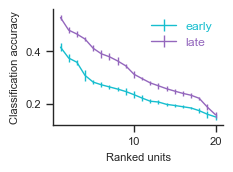

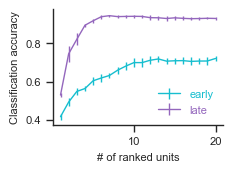

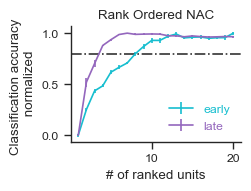

In [23]:
print(accuracy_inc_days_bs.shape) # n_days x n_bs x n_rankedunits

sns.set_context('paper')
sns.set_style('ticks')
plt.figure(figsize=(2.2,1.5))
plt.errorbar(np.arange(n_neurons)+1,np.mean(accuracy_inc_days_bs[0,:,:], axis = 0), yerr = np.std(accuracy_inc_days_bs[0,:,:], axis = 0), color = 'tab:cyan', label = 'early', linewidth = 1.0)
plt.errorbar(np.arange(n_neurons)+1,np.mean(accuracy_inc_days_bs[1,:,:], axis = 0), yerr = np.std(accuracy_inc_days_bs[1,:,:], axis = 0), color = 'tab:purple', label = 'late', linewidth = 1.0)
plt.ylabel('Classification accuracy', fontsize = 8)
plt.xlabel('Ranked units', fontsize = 8)
plt.legend(frameon = False, labelcolor = 'linecolor')
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
sns.despine()


plt.figure(figsize=(2.2,1.5))
sns.set_context('paper')
sns.set_style('ticks')
plt.errorbar(np.arange(n_neurons)+1,np.mean(accuracy_ndc_days_bs[0,:,:], axis = 0), yerr = np.std(accuracy_ndc_days_bs[0,:,:], axis = 0), color = 'tab:cyan', label = 'early', linewidth = 1.0)
plt.errorbar(np.arange(n_neurons)+1,np.mean(accuracy_ndc_days_bs[1,:,:], axis = 0), yerr = np.std(accuracy_ndc_days_bs[1,:,:], axis = 0), color = 'tab:purple', label = 'late', linewidth = 1.0)
plt.ylabel('Classification accuracy', fontsize = 8)
plt.xlabel('# of ranked units', fontsize = 8)
plt.legend(frameon = False, labelcolor = 'linecolor', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
sns.despine()
# f_name = os.path.join(PLOTS_DIR, 'RankOrderedNDC_all_paper.pdf')
# plt.savefig(f_name, dpi = 300)

# Normalizing to align 
sns.set_context('paper')
sns.set_style('ticks')
plt.figure(figsize=(2.2, 1.5))
acc_early = accuracy_ndc_days_bs[0,:,:]
m_a_early = np.mean(acc_early,axis = 0) # mean along bootstrap 
norm_acc_early =( m_a_early - np.min(m_a_early)) /(np.max(m_a_early)- np.min(m_a_early))
print(acc_early.shape)

acc_late =  accuracy_ndc_days_bs[1,:,:]
m_a_late =  np.mean(acc_late,axis = 0)
norm_acc_late =( m_a_late - np.min(m_a_late)) / (np.max(m_a_late)- np.min(m_a_late))
print(acc_late.shape)

plt.errorbar(np.arange(n_neurons)+1, norm_acc_early, yerr=np.std(acc_early,axis =0) ,color = 'tab:cyan', label = 'early')
plt.errorbar(np.arange(n_neurons)+1, norm_acc_late, yerr=np.std(acc_late,axis =0), color = 'tab:purple', label = 'late')
plt.axhline(y = 0.8, color = 'k', alpha = 0.8, linestyle = '-.')
plt.legend(frameon = False, labelcolor = 'linecolor')
plt.xlabel('# of ranked units')
plt.ylabel('Classification accuracy \n normalized')
plt.title('Rank Ordered NAC')
sns.despine()
